In [32]:
import os
import json
from natsort import natsorted
import re
from pprint import pprint
import pandas as pd
import numpy as np

### 1. Analyze input files

In [33]:
def create_benchmark_json():
    data = {"benchmark": {}}

    def is_text(file_path):
        try:
            with open(file_path, 'r') as f:
                f.readline()
            return True
        except UnicodeDecodeError:
            return False

    for root, dirs, files in os.walk('initial_benchmarks'):
        files = natsorted(files)
        for file in files:
            file_path = os.path.join(root, file)

            if not is_text(file_path):
                continue

            with open(file_path, 'r') as f:
                line = f.readline().strip()
                nbVariables, nbConstraints = map(int, line.split())

            path_split = os.path.split(file_path)
            folder = path_split[0].replace('initial_benchmarks/', '')
            instanceName = path_split[1]

            if folder not in data["benchmark"]:
                data["benchmark"][folder] = {}

            data["benchmark"][folder][instanceName] = {"nbVariables": nbVariables, "nbConstraints": nbConstraints}

    with open('benchmarks.json', 'w') as f:
        json.dump(data, f, indent=4)

In [34]:
def count_instances_per_benchmark(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    counts = {}

    for folder in data:
        counts[folder] = len(data[folder])
    
    return counts

In [35]:
counts = count_instances_per_benchmark('benchmarks.json')

for folder, count in counts.items():
    print(f"{folder}: {count} instances")

orrz-dtp: 100 instances
industrial-1-dtp: 100 instances
fhcpcs-tcsp: 100 instances
dimacs-gc-tcsp: 63 instances


### 2. Read output files

In [36]:
def load_execution_data(root_folder):
    data = {}

    for root, dirs, files in os.walk(root_folder):
        # Only process .out files
        files = [f for f in files if f.endswith('.out')]
        
        for file in files:
            # Split the path into components
            components = os.path.normpath(os.path.join(root, file)).split(os.sep)
            
            # Extract the solver, configuration, strategy, benchmark, and instance name
            solver = components[1]

            strategy = components[2]
            if strategy == "sat":
                benchmark = components[3]
                instanceName = components[4].replace('.out', '')

                # Initialize the nested dictionary structure if it doesn't already exist
                if benchmark not in data:
                    data[benchmark] = {}
                if solver not in data[benchmark]:
                    data[benchmark][solver] = {}
                if strategy not in data[benchmark][solver]:
                    data[benchmark][solver][strategy] = []
            else:
                heuristic = components[3]
                benchmark = components[4]
                instanceName = components[5].replace('.out', '')
                if benchmark not in data:
                    data[benchmark] = {}
                if solver not in data[benchmark]:
                    data[benchmark][solver] = {}
                if strategy not in data[benchmark][solver]:
                    data[benchmark][solver][strategy] = {}
                if heuristic not in data[benchmark][solver][strategy]:
                    data[benchmark][solver][strategy][heuristic] = []
                    
            # Initialize the lists for storing times and values
            times = []
            values = []
            
            # Read the execution data from the file
            with open(os.path.join(root, file), 'r') as f:
                for line in f:
                    splitted = line.strip().split(',')
                    if len(splitted) == 2:
                        # Split the line into time and value
                        time, value = line.strip().split(',')
                        
                        time = re.sub(r'[^\d.]+', '', time)

                        try:
                            times.append(float(time))
                            values.append(value.strip())
                        except ValueError:
                            print(f"Failed to parse time value '{time}' in file: {root}/{file}")
            
            if strategy == "sat":
                data[benchmark][solver][strategy].append({"instance": instanceName, "times": times, "values": values})
            else:
                data[benchmark][solver][strategy][heuristic].append({"instance": instanceName, "times": times, "values": values})
    
    return data

execution_data = load_execution_data('results')

Failed to parse time value '' in file: results/minicp/relaxed/max_regret/orrz-dtp/064.tn.out
Failed to parse time value '' in file: results/minicp/relaxed/max_regret/orrz-dtp/152.tn.out
Failed to parse time value '' in file: results/minicp/relaxed/max_regret/orrz-dtp/146.tn.out


In [37]:
def count_solutions(data):
    solution_counts = {}

    for benchmark, solvers in data.items():
        for solver, strategies in solvers.items():
            for strategy, strategy_or_heuristics in strategies.items():
                for key, instances in strategy_or_heuristics.items():
                    if isinstance(instances[0], dict):  # This means we're at a 'sat' or heuristic level
                        count = sum(1 for instance_data in instances if instance_data["values"] and "0" in instance_data["values"])
                        solution_key = (benchmark, solver, strategy, key)  # key could be a strategy ('sat') or a heuristic
                        solution_counts[solution_key] = count
                    else:  # We're at an instance level
                        instanceName = key
                        instance_data = strategy_or_heuristics[instanceName]
                        count = 1 if instance_data["values"] and "0" in instance_data["values"] else 0
                        solution_key = (benchmark, solver, strategy)
                        solution_counts[solution_key] = solution_counts.get(solution_key, 0) + count

    return solution_counts

# solution_counts = count_solutions(execution_data)

def count_solutions(instances):
    count = 0
    for instance in instances:
        count += 1 if instance["values"] and ("0" in instance["values"] or "(sat)" in instance["values"]) else 0
    return count

solution_counts = {}
for benchmark, solvers in execution_data.items():
    for solver, data in solvers.items():
        for strategy, data2 in data.items():
            if strategy == "sat":
                key = (benchmark, solver, strategy)
                solution_counts[key] = count_solutions(data2)
            else:
                for heuristic, data3 in data2.items():
                    key = (benchmark, solver, strategy, heuristic)
                    solution_counts[key] = count_solutions(data3)
                        
pprint(solution_counts)

{('dimacs-gc-tcsp', 'chuffed', 'relaxed', 'first_fail'): 20,
 ('dimacs-gc-tcsp', 'chuffed', 'relaxed', 'max_regret'): 19,
 ('dimacs-gc-tcsp', 'chuffed', 'sat'): 30,
 ('dimacs-gc-tcsp', 'gecode', 'relaxed', 'first_fail'): 24,
 ('dimacs-gc-tcsp', 'gecode', 'relaxed', 'max_regret'): 19,
 ('dimacs-gc-tcsp', 'gecode', 'sat'): 34,
 ('dimacs-gc-tcsp', 'minicp', 'relaxed', 'first_fail'): 27,
 ('dimacs-gc-tcsp', 'minicp', 'relaxed', 'max_regret'): 25,
 ('dimacs-gc-tcsp', 'minicp', 'sat'): 30,
 ('fhcpcs-tcsp', 'chuffed', 'relaxed', 'first_fail'): 0,
 ('fhcpcs-tcsp', 'chuffed', 'relaxed', 'max_regret'): 0,
 ('fhcpcs-tcsp', 'chuffed', 'sat'): 0,
 ('fhcpcs-tcsp', 'gecode', 'relaxed', 'first_fail'): 0,
 ('fhcpcs-tcsp', 'gecode', 'relaxed', 'max_regret'): 0,
 ('fhcpcs-tcsp', 'gecode', 'sat'): 0,
 ('fhcpcs-tcsp', 'minicp', 'relaxed', 'first_fail'): 0,
 ('fhcpcs-tcsp', 'minicp', 'relaxed', 'max_regret'): 0,
 ('fhcpcs-tcsp', 'minicp', 'sat'): 0,
 ('industrial-1-dtp', 'chuffed', 'relaxed', 'first_fail'):

In [38]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(solution_counts.items()), columns=["Key", "Count"])

# If the key tuple has only 3 elements, append 'None' as heuristic
df["Key"] = df["Key"].apply(lambda x: (*x, None) if len(x) == 3 else x)

# Split the Key tuple into separate columns
df[["Benchmark", "Solver", "Strategy", "Heuristic"]] = pd.DataFrame(df["Key"].tolist(), index=df.index)
df.drop("Key", axis=1, inplace=True)

# Rearrange the columns
df = df[["Benchmark", "Solver", "Strategy", "Heuristic", "Count"]]

# Print the DataFrame
print(df)

           Benchmark   Solver Strategy   Heuristic  Count
0           orrz-dtp   gecode      sat        None      1
1           orrz-dtp   gecode  relaxed  max_regret      0
2           orrz-dtp   gecode  relaxed  first_fail      0
3           orrz-dtp   minicp      sat        None      1
4           orrz-dtp   minicp  relaxed  max_regret      0
5           orrz-dtp   minicp  relaxed  first_fail      0
6           orrz-dtp  chuffed      sat        None      1
7           orrz-dtp  chuffed  relaxed  max_regret      0
8           orrz-dtp  chuffed  relaxed  first_fail      0
9   industrial-1-dtp   gecode      sat        None     34
10  industrial-1-dtp   gecode  relaxed  max_regret      0
11  industrial-1-dtp   gecode  relaxed  first_fail      0
12  industrial-1-dtp   minicp      sat        None     94
13  industrial-1-dtp   minicp  relaxed  max_regret     15
14  industrial-1-dtp   minicp  relaxed  first_fail      3
15  industrial-1-dtp  chuffed      sat        None     73
16  industrial

### 3. Violations vs Time elapsed

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
import json

def load_initial_constraints(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

In [41]:
def process_execution_data(execution_data, initial_constraints):
    for benchmark, benchmark_data in execution_data.items():
        config_df_dict = {}
        for solver, solver_data in benchmark_data.items():
            for strategy, strategy_data in solver_data.items():
                if strategy == "relaxed":
                    for heuristic, heuristic_data in strategy_data.items():
                        config_name, df_total = process_benchmark_data(
                            benchmark, solver, strategy, heuristic, heuristic_data, initial_constraints)
                        config_df_dict[config_name] = df_total
        
        print_results(benchmark, config_df_dict)  # print the results
        plot_data(benchmark, config_df_dict)

def print_results(benchmark, config_df_dict):
    with open(f'{benchmark}_results.txt', 'w') as f:
        for config, df in config_df_dict.items():
            # Reducing dataframe to include only intervals of 5 seconds
            df_reduced = df[df['time'] % 5 == 0]
            
            # Rounding to 2 decimal places and dropping 'normalized_violations' column
            df_reduced = df_reduced.round(2).drop(columns='normalized_violations')

            f.write(f"Results for Benchmark: {benchmark}, Configuration: {config}\n")
            f.write(df_reduced.to_string(index=False))  # index=False to avoid printing index
            f.write("\n\n")

def process_benchmark_data(benchmark, solver, strategy, heuristic, data, initial_constraints):
    df_total = pd.DataFrame(columns=['time', 'violated_constraints', 'nb_constraints'])

    for instance_data in data:
        instance = instance_data['instance']
        nb_constraints = initial_constraints[benchmark][instance]['nbConstraints']

        times = pd.Series(instance_data['times']).div(1000).apply(np.ceil).astype(int)
        values = pd.Series(instance_data['values']).astype(float)

        temp_df = pd.DataFrame({"time": times, "violated_constraints": values})
        temp_df['nb_constraints'] = nb_constraints
        temp_df['normalized_violations'] = temp_df['violated_constraints'] / temp_df['nb_constraints']

        temp_df = temp_df.groupby('time')['normalized_violations'].min().reset_index()

        temp_df.set_index('time', inplace=True)
        temp_df = temp_df.reindex(range(0, 61), method='ffill').reset_index()
        temp_df.loc[temp_df['time'] == 0, 'normalized_violations'] = 1
        temp_df['normalized_violations'] = temp_df['normalized_violations'].fillna(method='ffill')

        df_total = pd.concat([df_total, temp_df])

    df_total = df_total.groupby('time')["normalized_violations"].mean().reset_index()

    df_total.set_index('time', inplace=True)
    df_total = df_total.reindex(range(0, 61), method='ffill').reset_index()

    df_total['satisfaction_percentage'] = (1 - df_total['normalized_violations']) * 100

    # Here we just concatenate the actual values without labels
    config_name = f"{solver}"
    if heuristic is not None:
        config_name += f", {heuristic}"

    return config_name, df_total


import matplotlib.pyplot as plt
import seaborn as sns

def plot_data(benchmark, config_df_dict):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))

    line_styles = ['-', '--', '-.', ':']
    marker_styles = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', '+', 'x', 'D']
    
    for i, (config, df_total) in enumerate(config_df_dict.items()):
        ax.plot(df_total['satisfaction_percentage'], df_total['time'],
                label=config, linewidth=2, linestyle=line_styles[i % len(line_styles)],
                marker=marker_styles[i % len(marker_styles)], markevery=5, alpha=0.7)

    ax.set_title(f"Benchmark: {benchmark}", fontsize=16, fontweight='bold')
    ax.set_xlabel('Average % Satisfaction', fontsize=14)
    ax.set_ylabel('Time (s)', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 14})

    plt.savefig(f"{benchmark}_performance.png", dpi=300)
    plt.show()

Failed to parse time value '' in file: results/minicp/relaxed/max_regret/orrz-dtp/064.tn.out
Failed to parse time value '' in file: results/minicp/relaxed/max_regret/orrz-dtp/152.tn.out
Failed to parse time value '' in file: results/minicp/relaxed/max_regret/orrz-dtp/146.tn.out


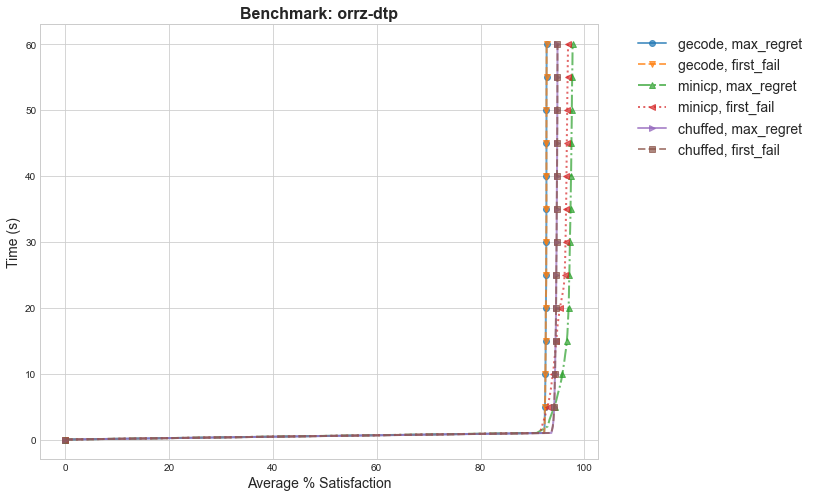

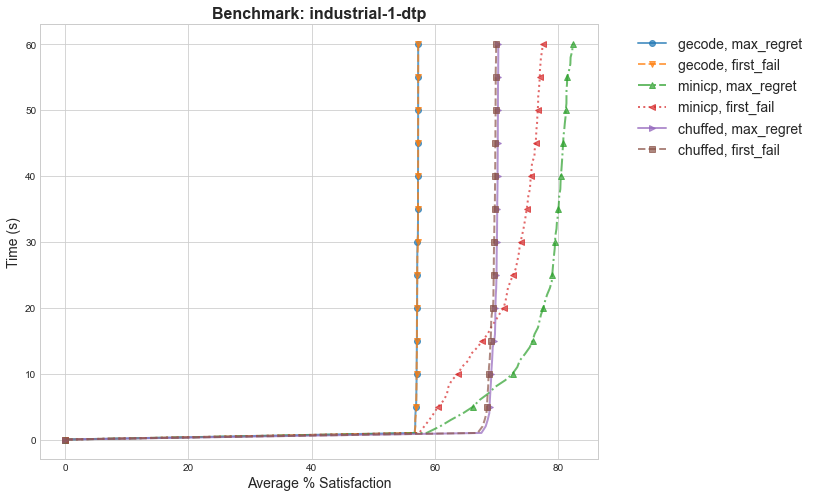

/var/folders/x5/74_vx8dn1l90l134c35grgj40000gn/T/ipykernel_8356/3068370749.py:35: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  times = pd.Series(instance_data['times']).div(1000).apply(np.ceil).astype(int)
/var/folders/x5/74_vx8dn1l90l134c35grgj40000gn/T/ipykernel_8356/3068370749.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series(instance_data['values']).astype(float)


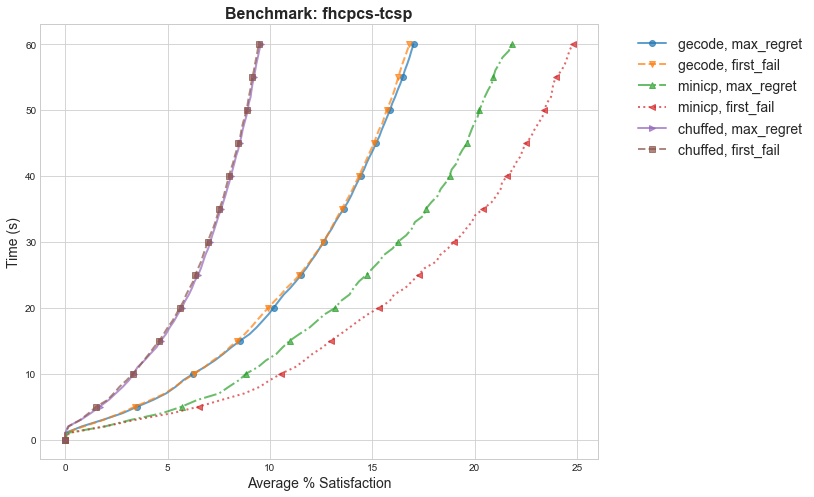

/var/folders/x5/74_vx8dn1l90l134c35grgj40000gn/T/ipykernel_8356/3068370749.py:35: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  times = pd.Series(instance_data['times']).div(1000).apply(np.ceil).astype(int)
/var/folders/x5/74_vx8dn1l90l134c35grgj40000gn/T/ipykernel_8356/3068370749.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  values = pd.Series(instance_data['values']).astype(float)


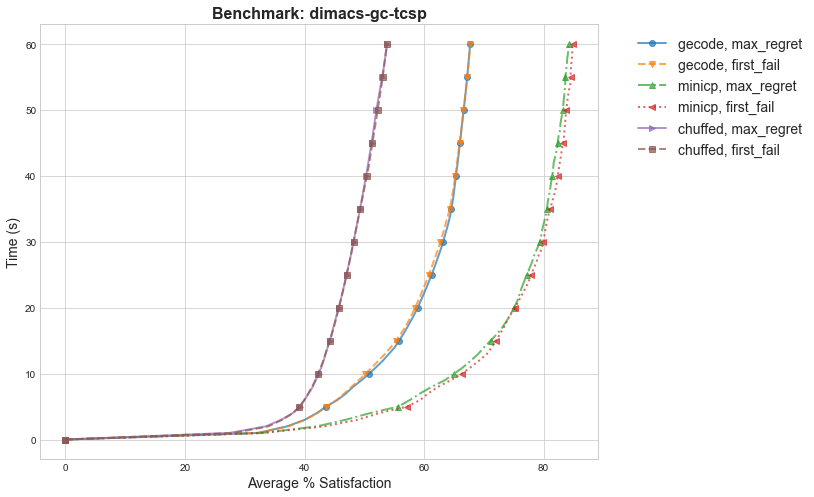

In [42]:
execution_data = load_execution_data('results')
initial_constraints = load_initial_constraints('benchmarks.json')
process_execution_data(execution_data, initial_constraints)